<a href="https://colab.research.google.com/github/AimjGuytidy/WQU-Thesis/blob/main/NBEATS_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
%pip install --quiet nbeats-keras

In [2]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

from nbeats_keras.model import NBeatsNet

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
df = pd.read_csv('/content/oil.csv')
print(df.head())
print(len(df))

           Date  Price
0  Aug 25, 2017  47.65
1  Aug 28, 2017  46.40
2  Aug 29, 2017  46.46
3  Aug 30, 2017  45.96
4  Aug 31, 2017  47.26
1005


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Price
0,2017-08-25,47.65
1,2017-08-28,46.40
2,2017-08-29,46.46
3,2017-08-30,45.96
4,2017-08-31,47.26


In [6]:
df.values.flatten()

array([Timestamp('2017-08-25 00:00:00'), 47.65,
       Timestamp('2017-08-28 00:00:00'), ..., 68.84,
       Timestamp('2021-08-30 00:00:00'), 69.28], dtype=object)

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data.reshape(data.shape[0], data.shape[1], 1), labels.reshape(labels.shape[0], 1, 1)

In [8]:
class DataNormalizer:

    def __init__(self, train):
        self.uni_train_mean = train.mean()
        self.uni_train_std = train.std()

    def apply(self, x):
        return (x - self.uni_train_mean) / self.uni_train_std

    def apply_inv(self, x):
        return x * self.uni_train_std + self.uni_train_mean

In [9]:
TRAIN_SPLIT = 805

uni_data = df['Price']
uni_data.index = df['Date']

uni_data = uni_data.values

In [10]:
uni_data

array([47.65, 46.4 , 46.46, ..., 67.42, 68.84, 69.28])

In [11]:
dn = DataNormalizer(train=uni_data[:TRAIN_SPLIT])
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = dn.apply(uni_data)

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print('x_train_uni.shape=', x_train_uni.shape)
print('y_train_uni.shape=', y_train_uni.shape)
print('x_val_uni.shape=', x_val_uni.shape)
print('y_val_uni.shape=', y_val_uni.shape)

x_train_uni.shape= (785, 20, 1)
y_train_uni.shape= (785, 1, 1)
x_val_uni.shape= (180, 20, 1)
y_val_uni.shape= (180, 1, 1)


In [12]:
b_val_uni = np.mean(x_val_uni, axis=1)[..., 0]
print(np.mean(np.abs(b_val_uni - y_val_uni)))
print(np.mean(np.abs(dn.apply_inv(b_val_uni) - dn.apply_inv(y_val_uni))))

0.70700408120963
9.16352061728395


In [13]:
b2_val_uni = x_val_uni[:, -1, 0]
print(np.mean(np.abs(b2_val_uni - y_val_uni)))
print(np.mean(np.abs(dn.apply_inv(b2_val_uni) - dn.apply_inv(y_val_uni))))

0.6721394137540546
8.711637654320988


In [14]:
m = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    nb_blocks_per_stack=3,
    forecast_length=1,
    backcast_length=univariate_past_history,
    thetas_dim=(15, 15, 15),
    share_weights_in_stack=False,
    hidden_layer_units=384)
m.compile(loss='mse', optimizer='adam')

In [15]:
class EvaluateModelCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        b3_val_uni = m.predict(x_val_uni)
        print(f'[{epoch}] b3_val_uni.shape=', b3_val_uni.shape)
        print(np.mean(np.abs(b3_val_uni - y_val_uni)))
        print(np.mean(np.abs(dn.apply_inv(b3_val_uni) - dn.apply_inv(y_val_uni))))
        print(f'MAPE:{np.mean(np.abs((dn.apply_inv(b3_val_uni) - dn.apply_inv(y_val_uni))/dn.apply_inv(y_val_uni)))}')
        print(f'RMSE:{np.sqrt(np.mean(np.square(dn.apply_inv(b3_val_uni) - dn.apply_inv(y_val_uni))))}')
        print('*' * 80)

In [16]:
tf.random.set_seed(42)
m.fit(x_train_uni, y_train_uni,
      epochs=20, validation_split=0.1, shuffle=True,
      callbacks=[EvaluateModelCallback()])

Epoch 1/20
23/23 [==============================] - 5s 68ms/step - loss: 2.1361 - val_loss: 0.0417
[0] b3_val_uni.shape= (180, 1, 1)
0.22166591810147548
2.873025889926487
MAPE:0.04640433417643559
RMSE:3.198968566870388
********************************************************************************
Epoch 2/20
23/23 [==============================] - 1s 44ms/step - loss: 0.1062 - val_loss: 0.0121
[1] b3_val_uni.shape= (180, 1, 1)
0.15317192628279547
1.9852712749905057
MAPE:0.03088620710699529
RMSE:2.357978153567381
********************************************************************************
Epoch 3/20
23/23 [==============================] - 1s 43ms/step - loss: 0.0577 - val_loss: 0.0701
[2] b3_val_uni.shape= (180, 1, 1)
0.15967823147755722
2.0695995788574226
MAPE:0.03213062457340882
RMSE:2.4275918861030097
********************************************************************************
Epoch 4/20
23/23 [==============================] - 1s 42ms/step - loss: 0.0555 - val_loss: 0.010

In [17]:
prediction = m.predict(x_val_uni).flatten()

In [18]:
true_val = y_val_uni.flatten()

In [19]:
k = dn.apply_inv(true_val)
k

array([46.59, 47.02, 47.58, 47.86, 48.34, 49.04, 47.79, 47.02, 47.94,
       48.18, 47.5 , 47.85, 48.24, 48.35, 47.47, 49.78, 50.45, 50.63,
       52.14, 52.15, 53.08, 52.81, 53.47, 52.25, 52.87, 53.16, 53.  ,
       52.28, 52.78, 52.61, 52.81, 52.26, 52.16, 53.55, 54.77, 55.67,
       56.19, 56.8 , 57.95, 58.34, 58.69, 58.22, 59.5 , 60.07, 61.09,
       60.4 , 59.12, 61.67, 61.66, 63.21, 63.43, 61.55, 60.54, 59.7 ,
       61.33, 63.81, 66.08, 65.03, 64.02, 64.45, 66.02, 65.59, 65.36,
       64.82, 64.55, 59.95, 61.43, 61.48, 57.75, 61.12, 58.47, 60.93,
       61.49, 60.55, 59.19, 61.41, 58.73, 59.34, 59.77, 59.61, 59.29,
       59.7 , 60.2 , 63.15, 63.42, 63.16, 63.33, 62.61, 61.34, 61.45,
       62.18, 62.02, 63.03, 63.81, 65.  , 63.5 , 64.46, 65.72, 65.63,
       64.73, 64.96, 64.92, 65.31, 65.96, 63.82, 65.32, 66.24, 65.49,
       63.28, 61.95, 63.61, 66.13, 66.27, 66.41, 66.87, 66.31, 67.8 ,
       68.79, 68.81, 69.57, 69.21, 70.11, 69.9 , 70.34, 71.  , 70.94,
       72.06, 72.03,

In [20]:
j = dn.apply_inv(prediction)
j

array([44.594246, 45.15255 , 45.833187, 46.390953, 46.82827 , 47.205692,
       47.597588, 47.40594 , 46.886497, 47.03532 , 47.36654 , 47.05213 ,
       46.62288 , 46.889442, 47.05616 , 46.69406 , 48.375748, 49.17578 ,
       49.801678, 50.55185 , 50.833313, 51.76963 , 52.00219 , 52.52648 ,
       52.368713, 52.50186 , 52.711014, 52.783535, 52.46309 , 52.645973,
       52.683556, 52.89276 , 52.716167, 52.837738, 53.679146, 54.789158,
       55.633007, 56.237415, 56.854134, 57.750023, 57.994434, 58.27173 ,
       57.771637, 58.23995 , 58.596455, 59.415054, 59.536716, 59.362686,
       60.407658, 60.653538, 61.64012 , 62.107933, 61.643658, 60.718468,
       60.094852, 61.119507, 63.023033, 64.8999  , 64.80926 , 64.07776 ,
       64.38232 , 65.52898 , 65.41915 , 65.54848 , 65.17195 , 64.48287 ,
       61.297573, 61.370914, 61.55882 , 58.541664, 60.565224, 59.24746 ,
       61.100277, 61.456955, 61.18259 , 60.261288, 61.61022 , 59.868977,
       59.40556 , 59.71512 , 59.087963, 58.943707, 

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

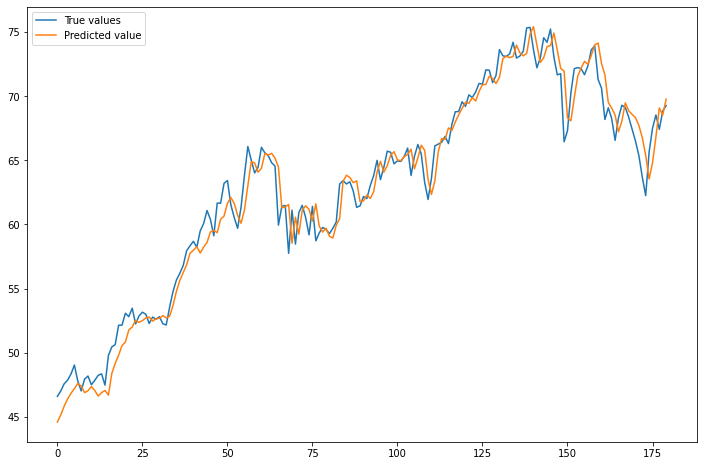

In [24]:
plt.figure(figsize=[12,8])
plt.plot(k,label='True values')
plt.plot(j,label='Predicted value')
plt.legend()
plt.show()

In [28]:
print('Evaluation Metrics')
print('*'*50)
print('\n')
print(f'MAPE:{np.mean(np.abs((j - k)/k))}')
print(f'RMSE:{np.sqrt(np.mean(np.square(j - k)))}')

Evaluation Metrics
**************************************************


MAPE:0.018258699669353874
RMSE:1.47061389979487
